# Mental Imagery classification using 1D-CNN


In [2]:
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D

load from database

In [3]:
df = pd.read_csv("EEG_DATA_CSV.csv")
df.EEG_DATA = df.EEG_DATA.map(json.loads)

select task 

In [4]:
Relax = df[(df.Tasks == 0) & (df.Subject == 1) ]
Star  = df[(df.Tasks == 1) & (df.Subject == 1)]

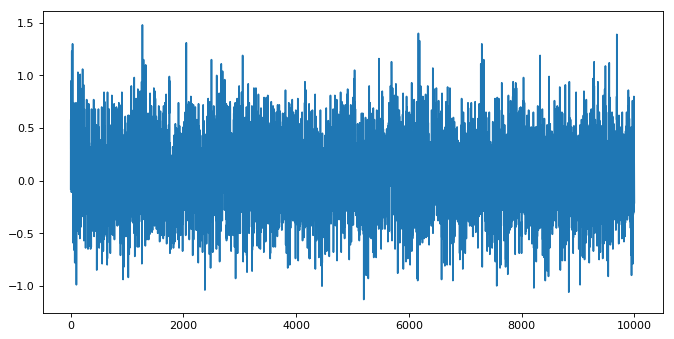

In [5]:
data_train_star_test = Star[(Star.Trial == 1) | (Star.Trial == 2) | (Star.Trial == 3)].EEG_DATA.tolist()
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(data_train_star_test[0])

In [6]:
data_train_relax = Relax[(Relax.Trial == 1) | (Relax.Trial == 2) | (Relax.Trial == 3) | (Relax.Trial == 4)].EEG_DATA.tolist()
data_train_relax = np.asarray(data_train_relax)
data_train_star = Star[(Star.Trial == 1) | (Star.Trial == 2) | (Star.Trial == 3)].EEG_DATA.tolist()
data_train_star = np.asarray(data_train_star)

In [7]:
def sliding_window(data, label, window_sz, n_hop, n_start=0, show_status=False):
    flag = 0
    for sample in range(data.shape[0]):
        tmp = np.array(
            [data[sample, i:i + window_sz ] for i in np.arange(n_start, data.shape[1] - window_sz + n_hop, n_hop)])
        tmp_lab = np.array([[label] for i in np.arange(n_start, data.shape[1] - window_sz + n_hop, n_hop)])
        if sample % 100 == 0 and show_status == True:
            print("Sample " + str(sample) + "processed!\n")
        if flag == 0:
            new_data = tmp
            new_lab = tmp_lab
            flag = 1
        else:
            new_data = np.concatenate((new_data, tmp))
            new_lab = np.concatenate((new_lab, tmp_lab))
    return new_data ,new_lab

In [8]:
data_train_relax,data_label_relax = sliding_window(data_train_relax,label= 0, window_sz= 300,n_hop= 5)
data_train_star,data_label_star = sliding_window(data_train_star,label= 1, window_sz= 300,n_hop= 5)

In [9]:
data_train = np.concatenate((data_train_relax,data_train_star),axis=0)
data_train = np.reshape(data_train,(data_train.shape[0],data_train.shape[1],1))
data_train.shape

(13587, 300, 1)

In [10]:
data_label = np.concatenate((data_label_relax,data_label_star),axis=0)
data_label = to_categorical(data_label)
data_label.shape

(13587, 2)

In [11]:
data_train_shuffled , data_label_shuffled = shuffle(data_train,data_label,random_state=0)
x_train, x_valid, y_train, y_valid = train_test_split(data_train_shuffled, data_label_shuffled , test_size=0.33, shuffle= True)

## CNN Architecture

In [12]:
def CNN_architecture(nb_filters):

    Inputmain = Input((300,1))

    Block = Conv1D(filters= nb_filters, kernel_size = 300,  padding='same', activation='relu'  )(Inputmain)
    Block = Flatten()(Block)
    Block = Dense(5, activation='relu')(Block)
    Dropout1 = Dropout(0.15)(Block)
    Output = Dense(2,activation='softmax')(Dropout1)

    model= Model(Inputmain, Output)
    
    return model

In [13]:
model = CNN_architecture(nb_filters=10)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 10)           3010      
_________________________________________________________________
flatten (Flatten)            (None, 3000)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 15005     
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 12        
Total params: 18,027
Trainable params: 18,027
Non-trainable params: 0
_________________________________________________________

In [14]:
history = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    epochs=15,verbose=1)

Epoch 1/15
285/285 [==============================] - 30s 10ms/step - loss: 0.3864 - accuracy: 0.8380 - val_loss: 0.1892 - val_accuracy: 0.9411
Epoch 2/15
285/285 [==============================] - 3s 9ms/step - loss: 0.1567 - accuracy: 0.9503 - val_loss: 0.0841 - val_accuracy: 0.9712
Epoch 3/15
285/285 [==============================] - 3s 9ms/step - loss: 0.0873 - accuracy: 0.9798 - val_loss: 0.0461 - val_accuracy: 0.9831
Epoch 4/15
285/285 [==============================] - 3s 9ms/step - loss: 0.0535 - accuracy: 0.9922 - val_loss: 0.0271 - val_accuracy: 0.9897
Epoch 5/15
285/285 [==============================] - 3s 10ms/step - loss: 0.0453 - accuracy: 0.9934 - val_loss: 0.0155 - val_accuracy: 0.9958
Epoch 6/15
285/285 [==============================] - 3s 9ms/step - loss: 0.0262 - accuracy: 0.9984 - val_loss: 0.0091 - val_accuracy: 0.9967
Epoch 7/15
285/285 [==============================] - 3s 9ms/step - loss: 0.0204 - accuracy: 0.9990 - val_loss: 0.0055 - val_accuracy: 0.9989
Epo

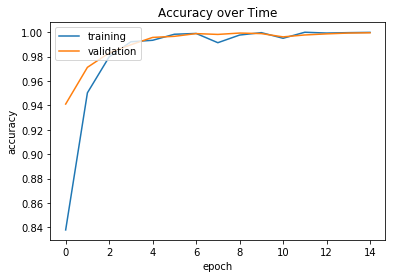

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over Time')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [17]:
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv1d (300, 1, 10)


In [18]:
filters, biases = model.layers[1].get_weights()

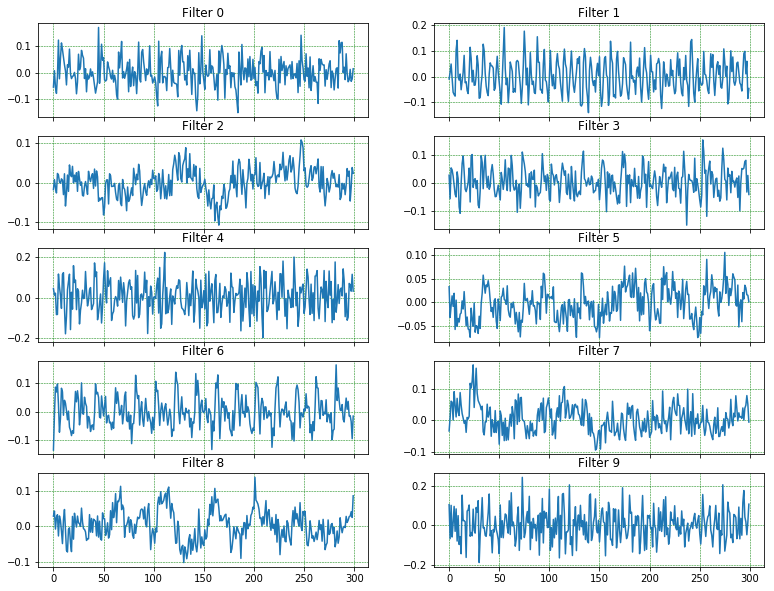

In [19]:
fig2, axes = plt.subplots(nrows=5, ncols=2,sharex='col')
for i, ax in enumerate(axes.flatten()):
       ax.plot(filters[:,:,i])
       ax.set(Title='Filter '+str(i))
       ax.grid(color='g', linestyle='dashed', linewidth=0.5)
fig2.set_size_inches(13,10)        
fig2.savefig('test.png',dpi=200,bbox_inches = 'tight',pad_inches=0)

Savingfilter in a CSV file

In [20]:
import pandas as pd

data = { 'Filt_No' : [],  'Output' : [] }

for i in range(0,10):
    data["Filt_No"].append(i+1)
    data["Output"].append(filters[:,:,i].reshape(300,).tolist())

df = pd.DataFrame(data, columns = ['Filt_No', 'Output'])
df.to_csv('Filters_subject1.csv')


Example on loading data

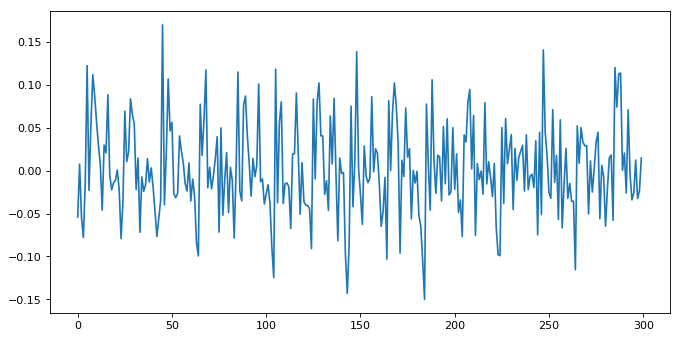

In [21]:
ff = pd.read_csv("Filters_subject1.csv")
ff.Output = ff.Output.map(json.loads)
filter1 = ff[(ff.Filt_No==1)]
filter1 = filter1.Output.tolist()
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(filter1[0])

In [22]:
def normalized(filt):
    ymax,ymin = filt.max(), filt.min()
    new_vect  = (filt - ymin)/(ymax-ymin)
    
    return new_vect

Text(0.31,0.08,'Frequency Hz')

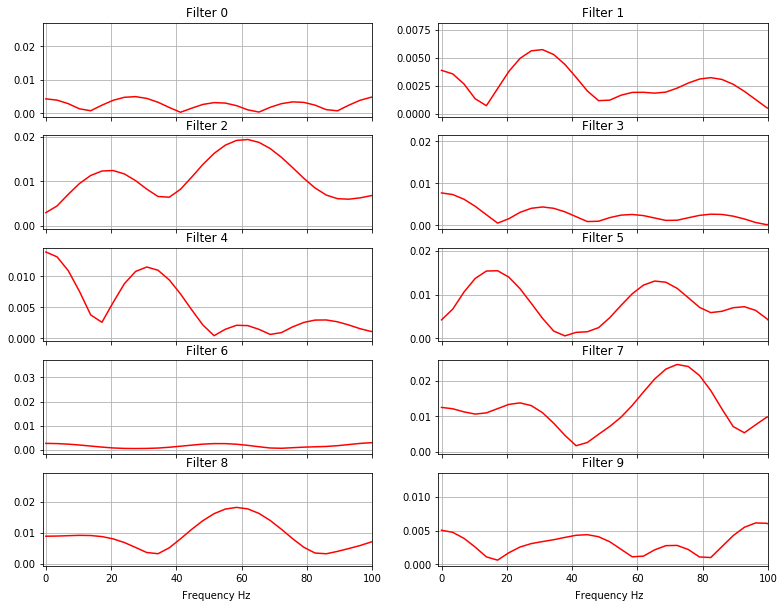

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 300
# sample spacing
T = 1 /1024
L= 2048
x = np.linspace(0.0, N*T, N)
fig3, axes = plt.subplots(nrows=5, ncols=2,sharex='col')
for i, ax in enumerate(axes.flatten()):
    h_padded = np.zeros(L)
    y = filters[:,:,i].reshape(300,)
    h_padded[0 : N] = y
    yf = scipy.fftpack.fft(h_padded) #zero padded
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    
    #plotting
    ax.set(Title='Filter '+str(i))
    ax.plot(xf, (2.0/N)*np.abs(yf[:N//2]),color= 'red')
    ax.grid()
    #plt.ylim(0,0.025)
    ax.set_xlim(-1,100)
    #ax.set_xlabel('Frequency Hz')

fig3.set_size_inches(13,10)
fig3.text(0.73, 0.08, 'Frequency Hz', ha='center')
fig3.text(0.31, 0.08, 'Frequency Hz', ha='center')

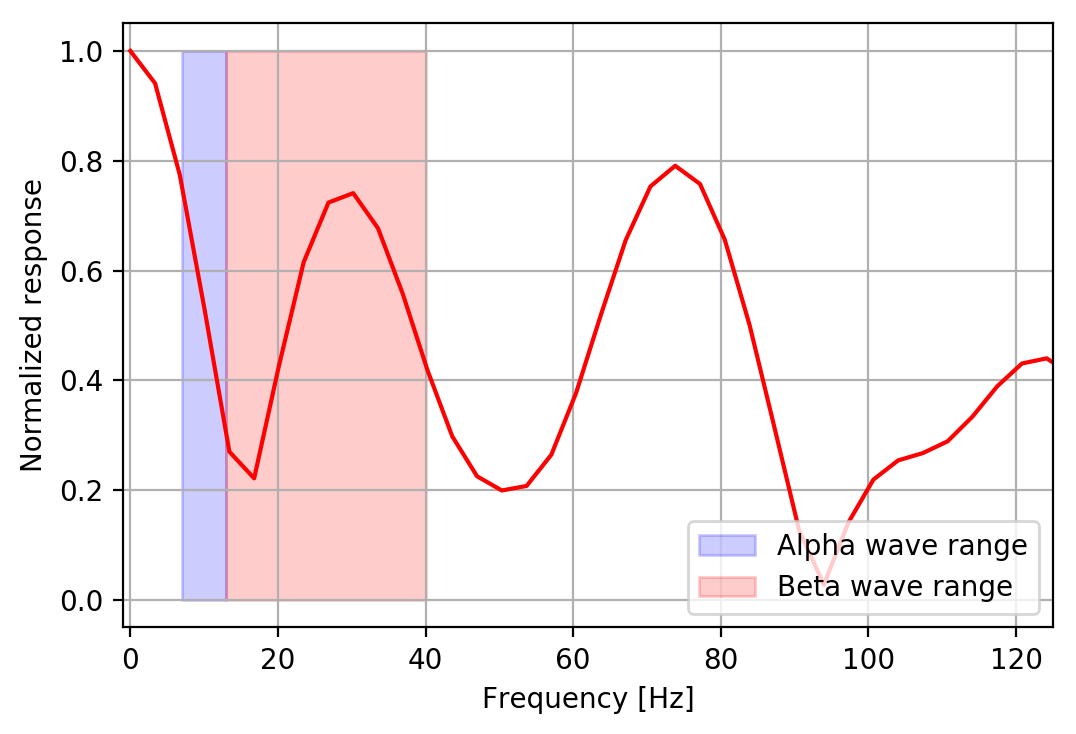

In [27]:


# Number of samplepoints
N = 300
# sample spacing
T = 1 /1000
x = np.linspace(0.0, N*T, N)
y = filters[:,:,5].reshape(300,)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

y_ftotal = []
for i in range(0,10):
    y_ftotal.append(scipy.fftpack.fft(filters[:,:,i].reshape(300,),n=2048))

y_ftotal = np.asarray(y_ftotal)

y_ftotal_mean = y_ftotal.mean(axis = 0)


std_tpr = y_ftotal.std(axis=0)

response = normalized((2.0/N)*np.abs(y_ftotal_mean[:N//2]))

alpha_range = np.zeros(len(xf))
alpha_range[0:5] = response[0:5]

fig4 = plt.figure(dpi=200)
plt.plot(xf, response,color = 'red')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Normalized response')
plt.fill_betweenx([0,1],7, 13, 
                 facecolor='orange', # The fill color
                 color='blue',       # The outline color
                 alpha=0.2,interpolate=False,
                 label  = 'Alpha wave range')   
plt.fill_betweenx([0,1],13, 40, 
                 facecolor='orange', # The fill color
                 color='red',       # The outline color
                 alpha=0.2,interpolate=False,
                 label  = 'Beta wave range') 

plt.legend(numpoints=1,             #Set the number of markers in label
           loc=('lower right'))
plt.grid()
#plt.ylim(0,0.025)
plt.xlim(-1,125)
plt.show()
fig4.savefig('total_response.png',bbox_inches = 'tight',pad_inches=0)

yf